# Credit Markets
## FINM 35700 - Spring 2024

### UChicago Financial Mathematics

* Alex Popovici
* alex.popovici@uchicago.edu

# Advanced Usage of QuantLib analytics library
## More details at: https://quantlib-python-docs.readthedocs.io/en/latest/

- 1\. SOFR OIS swap rates and SOFR discount curve calibration
  - a. SOFR curve calibration (via Bootstrapping)   
  - b. Display the calibrated SOFR discount curve dataframe
  - c. Plot the calibrated SOFR Zero Rates and Discount Factors curves
  - d. Validate SOFR calibration by pricing SOFR swaps
- 2\. Credit Default Swaps (CDS): calibration + pricing
  - a. CDS Hazard Rate calibration
  - b. Plot the calibrated Hazard Rate and Survival Probability curves
  - c. CDS valuation
- 3\. Pricing risky bonds in the CDS-implied Hazard Rate Model (with Credit Default Risk)
  - a. Create Corporate Bond
  - b. Price Corporate Bond on Risk-Free Yield Curve (without Credit Risk)
  - c. Compute Intrinsic Risky Bond Price on IBM CDS Credit Curve (with Credit Risk)
- 4\. Pricing risky bonds in Custom Hazard Rate Model (with Credit Default Risk)
  - a. Create and Display the Custom Credit Curve
  - b. Price Risky Bond on Custom Credit Curve (with Credit Risk)
- 5\. Smooth parametric yield and hazard rate curves: Nelson-Siegel + extensions
  - a. Nelson Siegel basis functions
  - b. Plot Basis Functions for Nelson-Siegel + extensions
  - c. Constructing smooth Nelson-Siegel hazard rate / survival probability curves
  - d. Pricing risky bonds in Nelson-Siegel model (with Credit Risk) 


In [1]:
import QuantLib as ql
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline


# 1. SOFR OIS swap rates and SOFR discount curve calibration

## a. SOFR curve calibration (via Bootstrapping)

Overnight Index Swap contract is an interest rate swap contract exchanging and overnight index interest rate (e.g. Fed Funds, SOFR, LIBOR) for a fixed interest rate until the contract maturity. The fixed rate is set at a rate agreed upon by both parties. The floating leg portion of the swap is compounded and paid at reset dates. 

In [2]:
# Set the static valuation date: 2023-04-14
calc_date = ql.Date(14, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date

# calendar
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)

# settle_days
settle_days = 2

# SOFR OIS swap tenors: 1Y, 2Y, 3Y, 5Y 7Y, 10Y, 20Y and 30Y
SOFR_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10, 20, 30]]
               
# SOFR OIS swap rates (as of 2023-04-14)
SOFR_rates = [4.81, 4.11, 3.73, 3.38, 3.32, 3.26, 3.20, 3.02]

SOFR_OIS_swap_helpers = []
for (SOFR_tenor, SOFR_rate) in zip(SOFR_tenors, SOFR_rates):
    SOFR_OIS_swap_helpers.append(ql.OISRateHelper(settle_days, SOFR_tenor, ql.QuoteHandle(ql.SimpleQuote(SOFR_rate/100)), ql.Sofr()))

# Create SOFR yield curve
sofr_yield_curve = ql.PiecewiseLinearZero(settle_days, calendar, SOFR_OIS_swap_helpers, ql.Actual360())
sofr_yield_curve.enableExtrapolation()
sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)

print(sofr_yield_curve.referenceDate())


April 18th, 2023


## b. Display the calibrated SOFR discount curve dataframe

In [3]:
def get_yield_curve_details_df(yield_curve, curve_dates=None):
    
    if(curve_dates == None):
        curve_dates = yield_curve.dates()

    dates = [d.to_date() for d in curve_dates]
    discounts = [round(yield_curve.discount(d), 3) for d in curve_dates]
    yearfracs = [round(yield_curve.timeFromReference(d), 3) for d in curve_dates]
    zeroRates = [round(yield_curve.zeroRate(d, yield_curve.dayCounter(), ql.Compounded).rate() * 100, 3) for d in curve_dates]

    yield_curve_details_df = pd.DataFrame(data={'Date': dates,
                             'YearFrac': yearfracs,
                             'DiscountFactor': discounts,
                             'ZeroRate': zeroRates})                             
    return yield_curve_details_df



# Display SOFR yield curve
grid_dates = [sofr_yield_curve.referenceDate() + ql.Period(y, ql.Years) for y in list(range(0,30,2))]


sofr_yield_curve_simple_df = get_yield_curve_details_df(sofr_yield_curve)                  # using calibration grid
sofr_yield_curve_details_df = get_yield_curve_details_df(sofr_yield_curve, grid_dates)    # using external grid

print(sofr_yield_curve_simple_df)
print(sofr_yield_curve_details_df)


         Date  YearFrac  DiscountFactor  ZeroRate
0  2023-04-18     0.000           1.000     4.808
1  2024-04-18     1.017           0.953     4.808
2  2025-04-21     2.039           0.921     4.094
3  2026-04-20     3.050           0.895     3.706
4  2028-04-18     5.075           0.846     3.347
5  2030-04-18     7.103           0.795     3.291
6  2033-04-18    10.147           0.724     3.232
7  2043-04-20    20.297           0.530     3.173
8  2053-04-18    30.439           0.415     2.931
          Date  YearFrac  DiscountFactor  ZeroRate
0   2023-04-18     0.000           1.000     4.808
1   2025-04-18     2.031           0.922     4.100
2   2027-04-18     4.058           0.869     3.527
3   2029-04-18     6.089           0.820     3.319
4   2031-04-18     8.117           0.770     3.272
5   2033-04-18    10.147           0.724     3.232
6   2035-04-18    12.175           0.680     3.221
7   2037-04-18    14.206           0.638     3.209
8   2039-04-18    16.233           0.600 

## c. Plot the calibrated SOFR Zero Rates and Discount Factors curves

Text(0.5, 0, 'Date')

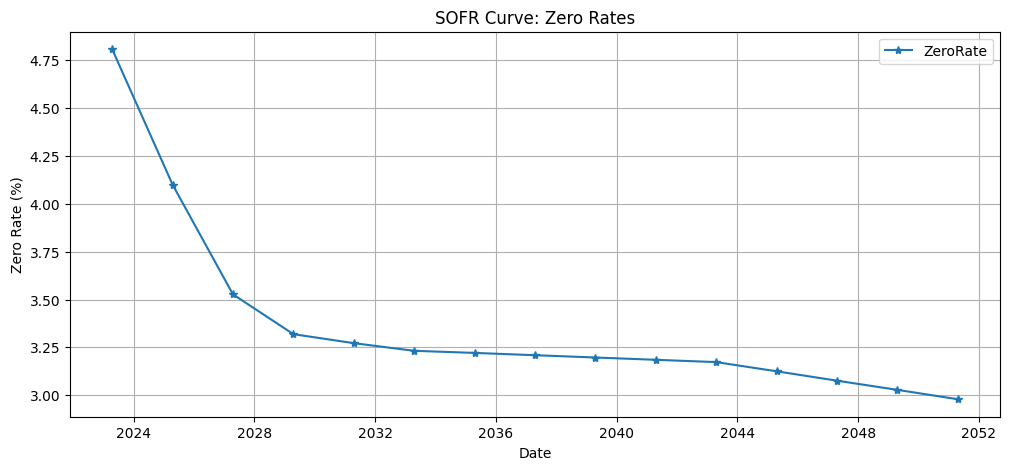

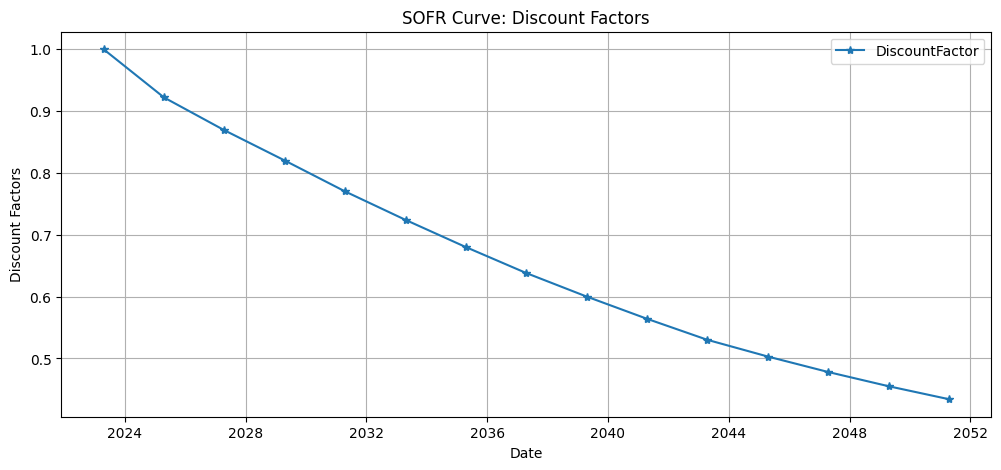

In [4]:
plt = sofr_yield_curve_details_df.plot(x='Date', y='ZeroRate', grid=True, style='*-', title='SOFR Curve: Zero Rates', figsize=(12,5))
plt.set_ylabel('Zero Rate (%)')
plt.set_xlabel('Date')

plt = sofr_yield_curve_details_df.plot(x='Date', y='DiscountFactor', grid=True, style='*-', title='SOFR Curve: Discount Factors', figsize=(12,5))
plt.set_ylabel('Discount Factors')
plt.set_xlabel('Date')

## d. Validate SOFR calibration by pricing SOFR swaps

In [5]:
# validate SOFR swaps
sofr_index = ql.Sofr(sofr_yield_curve_handle)
# swap_engine = ql.DiscountingSwapEngine(sofr_yield_curve_handle)

print('SOFR Swap valuation: PVs should be close to zero!')

for (SOFR_tenor, SOFR_rate) in zip(SOFR_tenors, SOFR_rates):    
    start_date = calendar.advance(calc_date, settle_days, ql.Days)
    schedule = ql.MakeSchedule(start_date, calendar.advance(start_date, SOFR_tenor), ql.Period('1Y'), calendar=calendar)        
    oisSwap = ql.MakeOIS(SOFR_tenor, sofr_index, SOFR_rate/100, nominal=100)
    
    # oisSwap.setPricingEngine(swap_engine)
    print('Swap PV for', SOFR_tenor, 'tenor /', SOFR_rate, 'coupon :', oisSwap.NPV()) 
    

SOFR Swap valuation: PVs should be close to zero!
Swap PV for 1Y tenor / 4.81 coupon : 0.0
Swap PV for 2Y tenor / 4.11 coupon : 2.842170943040401e-14
Swap PV for 3Y tenor / 3.73 coupon : -4.263256414560601e-14
Swap PV for 5Y tenor / 3.38 coupon : -4.033573475226149e-11
Swap PV for 7Y tenor / 3.32 coupon : -2.842170943040401e-14
Swap PV for 10Y tenor / 3.26 coupon : 7.105427357601002e-15
Swap PV for 20Y tenor / 3.2 coupon : -2.1316282072803006e-14
Swap PV for 30Y tenor / 3.02 coupon : -6.394884621840902e-14


# 2. Credit Default Swaps (CDS): calibration + pricing
## a. CDS Hazard Rate calibration


In [6]:
CDS_recovery_rate = 0.4

CDS_day_count = ql.Actual360()

# CDS standard tenors: 1Y, 2Y, 3Y, 5Y 7Y and 10Y
CDS_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10]]
              
# CDS spreads for IBM as of calc_date = 2023-04-14
CDS_spreads = [17.25, 24.09, 35.58, 55.58, 70.51, 79.92]

CDS_helpers = [ql.SpreadCdsHelper((CDS_spread / 10000.0), CDS_tenor, settle_days, ql.TARGET(),
                                  ql.Quarterly, ql.Following, ql.DateGeneration.TwentiethIMM, CDS_day_count, CDS_recovery_rate, sofr_yield_curve_handle)
               
for (CDS_spread, CDS_tenor) in zip(CDS_spreads, CDS_tenors)]

# bootstrap hazard_rate_curve
hazard_rate_curve = ql.PiecewiseFlatHazardRate(calc_date, CDS_helpers, CDS_day_count)
hazard_rate_curve.enableExtrapolation()

# Display calibrated hazard rates and survival probabilities
hazard_list = [(hr[0].to_date(), 
                CDS_day_count.yearFraction(calc_date, hr[0]),
                hr[1] * 100,
                np.exp(-hr[1]*CDS_day_count.yearFraction(calc_date, hr[0])),
                hazard_rate_curve.survivalProbability(hr[0])) for hr in hazard_rate_curve.nodes()]

grid_dates, year_frac, hazard_rates, sp_manual, surv_probs = zip(*hazard_list)

hazard_rates_df = pd.DataFrame(data={'Date': grid_dates, 
                                     'YearFrac': year_frac,
                                     'HazardRate': hazard_rates,
                                     'SPManual': sp_manual,
                                     'SurvivalProb': surv_probs})
print(hazard_rates_df)


         Date   YearFrac  HazardRate  SPManual  SurvivalProb
0  2023-04-14   0.000000    0.285237  1.000000      1.000000
1  2024-06-20   1.202778    0.285237  0.996575      0.996575
2  2025-06-20   2.216667    0.540041  0.988100      0.991133
3  2026-06-22   3.236111    1.033609  0.967104      0.980745
4  2028-06-20   5.261111    1.511140  0.923575      0.951188
5  2030-06-20   7.288889    1.925096  0.869082      0.914772
6  2033-06-20  10.333333    1.803340  0.829987      0.865903


## b. Plot the calibrated Hazard Rate and Survival Probability curves

Text(0.5, 0, 'Date')

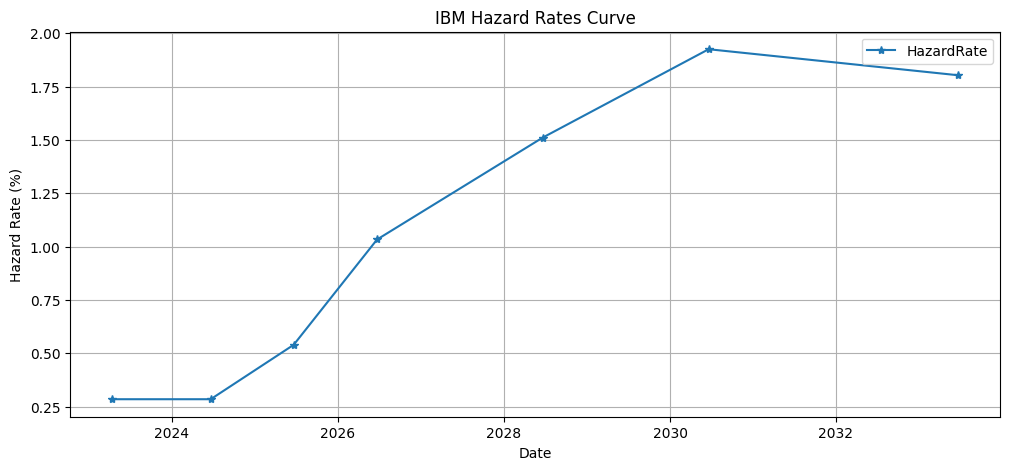

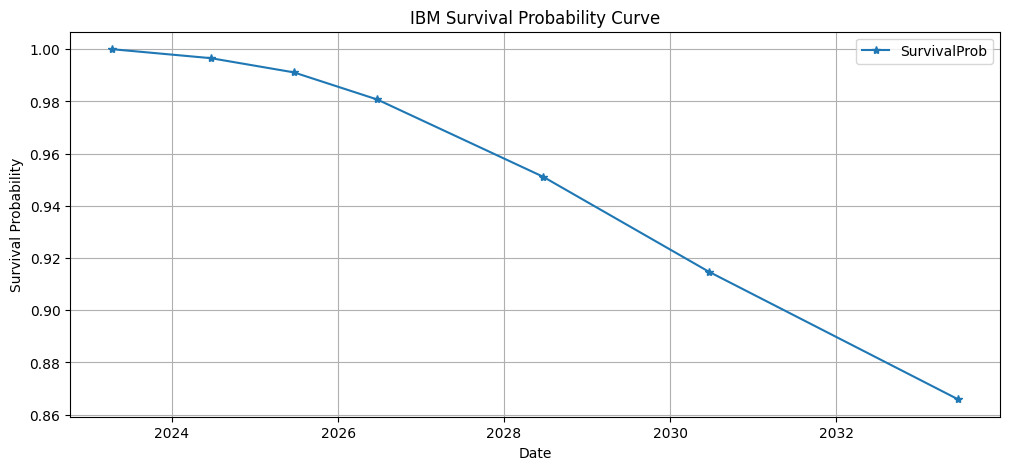

In [7]:
plt = hazard_rates_df.plot(x='Date', y='HazardRate', grid=True, style='*-', title='IBM Hazard Rates Curve', figsize=(12,5))
plt.set_ylabel('Hazard Rate (%)')
plt.set_xlabel('Date')

plt = hazard_rates_df.plot(x='Date', y='SurvivalProb', grid=True, style='*-', title='IBM Survival Probability Curve', figsize=(12,5))
plt.set_ylabel('Survival Probability')
plt.set_xlabel('Date')


## c. CDS valuation

In [8]:
# CDS specs
side = ql.Protection.Seller

face_notional = 100

contractual_spread = 100 / 10000

cds_start_date = ql.Date(14, 4, 2023)
cds_maturity_date = ql.Date(20, 6, 2028)

# Create CDS schedule
cds_schedule = ql.MakeSchedule(cds_start_date, cds_maturity_date, ql.Period('3M'),
                            ql.Quarterly, ql.TARGET(), ql.Following, ql.Unadjusted, ql.DateGeneration.TwentiethIMM)

# Create CDS object
cds_obj = ql.CreditDefaultSwap(side, face_notional, contractual_spread, cds_schedule, ql.Following, ql.Actual360())

# Create CDS Implied Credit Curve and pricing engine
cds_surv_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve)

cds_pricing_engine = ql.MidPointCdsEngine(cds_surv_prob_curve_handle, CDS_recovery_rate, sofr_yield_curve_handle)
cds_obj.setPricingEngine(cds_pricing_engine)


# Print CDS valuation results
print('CDS protection start date:', cds_obj.protectionStartDate())
print('CDS fair/par spread:', round(cds_obj.fairSpread()*10000, 3))
print('CDS PV:', round(cds_obj.NPV(), 4))    
print('CDS Premium Leg PV:', round(cds_obj.couponLegNPV(), 4))
print('CDS Default Leg PV', round(cds_obj.defaultLegNPV(), 4))
print('Survival Prob. to Maturity:', round(hazard_rate_curve.survivalProbability(cds_maturity_date), 4))


CDS protection start date: April 14th, 2023
CDS fair/par spread: 55.502
CDS PV: 2.0855
CDS Premium Leg PV: 4.6868
CDS Default Leg PV -2.6013
Survival Prob. to Maturity: 0.9512


# 3. Pricing risky bonds in the CDS-implied Hazard Rate Model (with Credit Default Risk)
## a. Create Corporate Bond

In [9]:
issue_date = ql.Date(14, 4, 2023)
maturity_date = ql.Date(14, 4, 2027)
coupon_freq = ql.Semiannual
coupon_term = ql.Period(coupon_freq)
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
day_count_conv = ql.Unadjusted
date_generation = ql.DateGeneration.Backward
month_end = True
schedule = ql.Schedule(issue_date,
                       maturity_date,
                       coupon_term,
                       calendar,
                       day_count_conv,
                       day_count_conv,
                       date_generation,
                       month_end)

# Corp Bonds specs
day_count = ql.Thirty360(ql.Thirty360.USA)
settlement_days = 2
coupon_rate = 0.04
coupons = [coupon_rate]
payment_convention = ql.Unadjusted

# Construct the FixedRateBond
face_value = 100
fixed_rate_bond = ql.FixedRateBond(
    settlement_days,
    face_value,
    schedule,
    coupons,
    day_count,
    payment_convention)

x = [(cf.date(), cf.amount()) for cf in fixed_rate_bond.cashflows()]
cf_date, cf_amount = zip(*x)
cf_frame = pd.DataFrame(data={'CashFlowDate': cf_date, 'CashFlowAmount': cf_amount})
print(cf_frame)


         CashFlowDate  CashFlowAmount
0  October 14th, 2023             2.0
1    April 14th, 2024             2.0
2  October 14th, 2024             2.0
3    April 14th, 2025             2.0
4  October 14th, 2025             2.0
5    April 14th, 2026             2.0
6  October 14th, 2026             2.0
7    April 14th, 2027             2.0
8    April 14th, 2027           100.0


## b. Price Corporate Bond on Risk-Free Yield Curve (without Credit Risk)

In [10]:
compounding = ql.Compounded
# compounding = ql.Continuous

day_counter = fixed_rate_bond.dayCounter()

risk_free_bond_engine = ql.DiscountingBondEngine(sofr_yield_curve_handle)

fixed_rate_bond.setPricingEngine(risk_free_bond_engine)
risk_free_bond_price = fixed_rate_bond.cleanPrice()
risk_free_bond_yield = fixed_rate_bond.bondYield(risk_free_bond_price, day_counter, ql.Compounded, ql.Semiannual) * 100

print('risk_free_bond_price:', risk_free_bond_price)
print('risk_free_bond_yield:', risk_free_bond_yield)


risk_free_bond_price: 101.54536292727957
risk_free_bond_yield: 3.5807016439305466


## c. Compute Intrinsic Risky Bond Price on IBM CDS Credit Curve (with Credit Risk)

In [11]:
# bond_recovery_rate
bond_recovery_rate = 0.4

# cds_curve_risky_bond_engine: using calibrated IBM CDS curve
cds_curve_risky_bond_engine = ql.RiskyBondEngine(cds_surv_prob_curve_handle, bond_recovery_rate, sofr_yield_curve_handle)
fixed_rate_bond.setPricingEngine(cds_curve_risky_bond_engine)

# 3. Calculate intrinsic risky bond on custom survival probability curve
risky_bond_price = fixed_rate_bond.cleanPrice()
risky_bond_yield = fixed_rate_bond.bondYield(risky_bond_price, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100

print('risky_bond_price:', risky_bond_price)
print('risky_bond_yield:', risky_bond_yield)

# Compute the credit I-Spread, relative to risk-free bond (SOFR curve)
risky_bond_credit_ispread_bps = (risky_bond_yield - risk_free_bond_yield) * 100
print('risky_bond_ispread_bps:', risky_bond_credit_ispread_bps)

# Calc z-spread
risky_bond_zspread_bps = ql.BondFunctions.zSpread(fixed_rate_bond, risky_bond_price, sofr_yield_curve, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 1e4
print('risky_bond_zspread_bps:', risky_bond_zspread_bps)



risky_bond_price: 99.77353776497536
risky_bond_yield: 4.061950922012331
risky_bond_ispread_bps: 48.12492780817843
risky_bond_zspread_bps: 47.384353360489136


# 4. Pricing risky bonds in Custom Hazard Rate Model (with Credit Default Risk)
## a. Create and Display the Custom Credit Curve

Text(0.5, 0, 'Date')

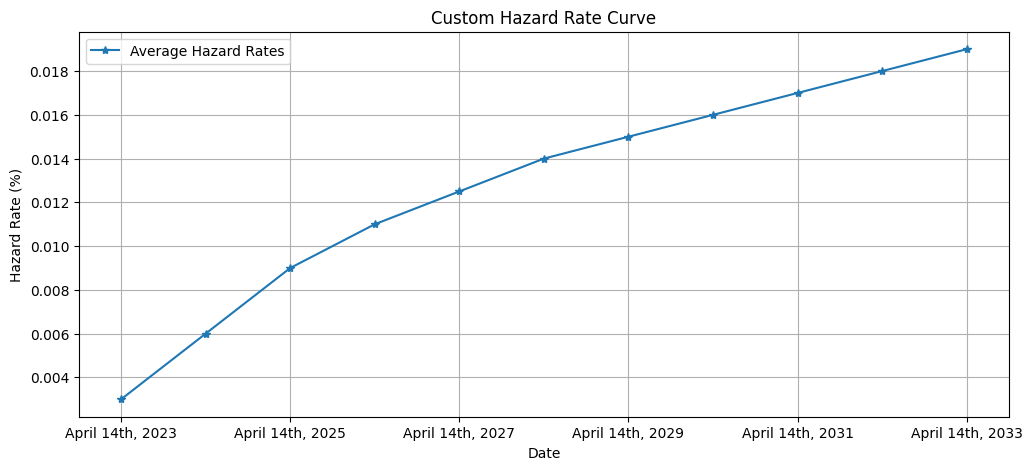

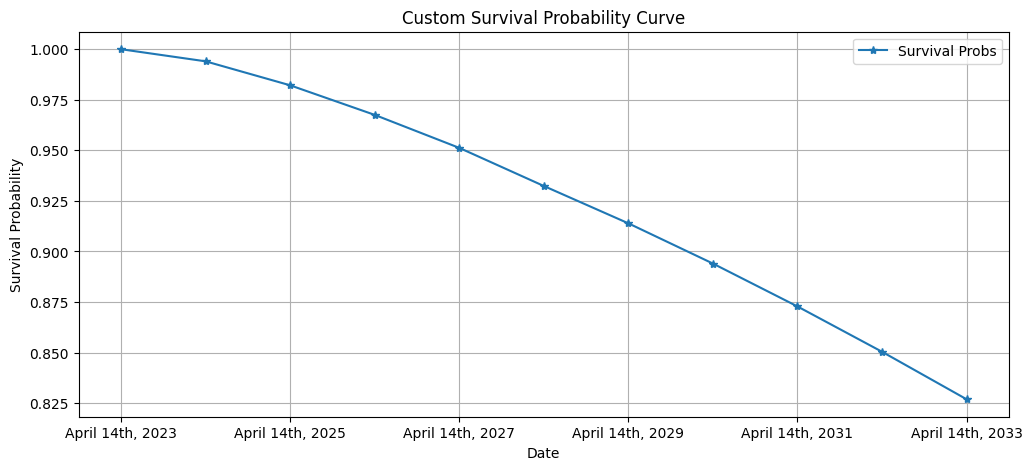

In [12]:
# 2. Create custom survival probability curve
custom_surv_prob_dates = [calc_date + ql.Period(T , ql.Years) for T in range(11)]
custom_average_hazard_rates = [0.0030, 0.0060, 0.0090, 0.0110, 0.0125, 0.0140, 0.0150, 0.0160, 0.0170, 0.0180, 0.0190]
custom_surv_prob_levels = [np.exp(-T * custom_average_hazard_rates[T]) for T in range(11)]
# custom_surv_prob_levels = [1.0, 0.9950, 0.9860, 0.9733, 0.9569, 0.9370, 0.9166, 0.8940, 0.8728, 0.8504, 0.8269]

# custom_surv_prob_curve
custom_surv_prob_curve = ql.SurvivalProbabilityCurve(custom_surv_prob_dates, custom_surv_prob_levels, ql.Actual360(), ql.TARGET())
custom_surv_prob_curve.enableExtrapolation()
custom_surv_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(custom_surv_prob_curve)

# 3. Display custom credit curve
custom_surv_prob_df = pd.DataFrame(data={'Date': custom_surv_prob_dates,
                                          'Average Hazard Rates': custom_average_hazard_rates,
                                          'Survival Probs': custom_surv_prob_levels})

plt = custom_surv_prob_df.plot(x='Date', y='Average Hazard Rates', grid=True, style='*-', title='Custom Hazard Rate Curve', figsize=(12,5))
plt.set_ylabel('Hazard Rate (%)')
plt.set_xlabel('Date')

plt = custom_surv_prob_df.plot(x='Date', y='Survival Probs', grid=True, style='*-', title='Custom Survival Probability Curve', figsize=(12,5))
plt.set_ylabel('Survival Probability')
plt.set_xlabel('Date')

## b. Price Risky Bond on Custom Credit Curve (with Credit Risk) 

In [13]:
# bond_recovery_rate
bond_recovery_rate = 0.4

# custom_curve_risky_bond_engine
custom_curve_risky_bond_engine = ql.RiskyBondEngine(custom_surv_prob_curve_handle, bond_recovery_rate, sofr_yield_curve_handle)
fixed_rate_bond.setPricingEngine(custom_curve_risky_bond_engine)

# 3. Price risky bond on custom survival probability curve
risky_bond_price = fixed_rate_bond.cleanPrice()
risky_bond_yield = fixed_rate_bond.bondYield(risky_bond_price, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100

print('risky_bond_price:', risky_bond_price)
print('risky_bond_yield:', risky_bond_yield)

# Compute the credit I-Spread, relative to risk-free bond (SOFR curve)
risky_bond_credit_ispread_bps = (risky_bond_yield - risk_free_bond_yield) * 100
print('risky_bond_ispread_bps:', risky_bond_credit_ispread_bps)

# Calc z-spread
risky_bond_zspread_bps = ql.BondFunctions.zSpread(fixed_rate_bond, risky_bond_price, sofr_yield_curve, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 1e4
print('risky_bond_zspread_bps:', risky_bond_zspread_bps)



risky_bond_price: 98.75601148481837
risky_bond_yield: 4.342892980575562
risky_bond_ispread_bps: 76.21913366450156
risky_bond_zspread_bps: 75.04528626811441


# 5. Smooth parametric yield and hazard rate curves: Nelson-Siegel + extensions
## a. Nelson Siegel basis functions

In [14]:
# nelson_siegel curve shape: Nelson-Siegel
def nelson_siegel(params, maturity):
    ''' params = (theta1, theta2, theta3, lambda)'''    
    
    if(maturity > 0):
        slope_1 = (1 - np.exp(-maturity/params[3]))/(maturity/params[3])
    else:            
        slope_1 = 1

    curvature_1 = slope_1 - np.exp(-maturity/params[3])

    total_value = params[0] + params[1] * slope_1 + params[2] * curvature_1
    
    return total_value

# nelson_siegel_extended curve shape: Nelson-Siegel-Svensson
def nelson_siegel_extended(params, maturity):

    if(maturity > 0):
        slope_1 = (1 - np.exp(-maturity/params[3]))/(maturity/params[3])
    else:            
        slope_1 = 1

    curvature_1 = slope_1 - np.exp(-maturity/params[3])

    total_value = params[0] + params[1] * slope_1 + params[2] * curvature_1    
    
    if(params[5] != 0):
        if(maturity > 0):
            slope_2 = (1 - np.exp(-maturity/params[5]))/(maturity/params[5])
        else:
            slope_2 = 1

        curvature_2 = slope_2 - np.exp(-maturity/params[5])

        total_value = total_value + params[4] * curvature_2
        
    
    return total_value


## b. Plot Basis Functions for Nelson-Siegel + extensions

   TTM  Level     Slope  Curvature_1  Curvature_2
0    0    1.0  1.000000     0.000000     0.000000
1    1    1.0  0.786939     0.360816     0.046788
2    2    1.0  0.632121     0.528482     0.087615
3    3    1.0  0.517913     0.589566     0.123121
4    4    1.0  0.432332     0.593994     0.153880


Text(0.5, 0, 'Time to maturity (years)')

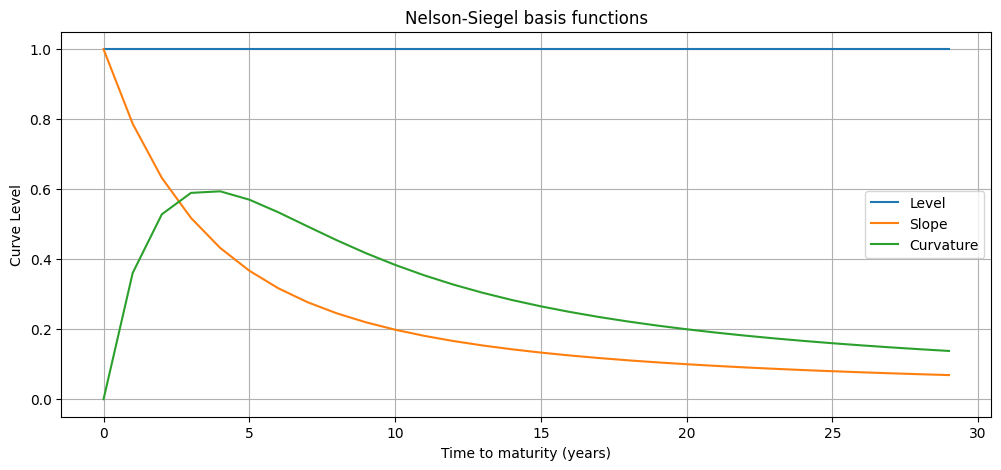

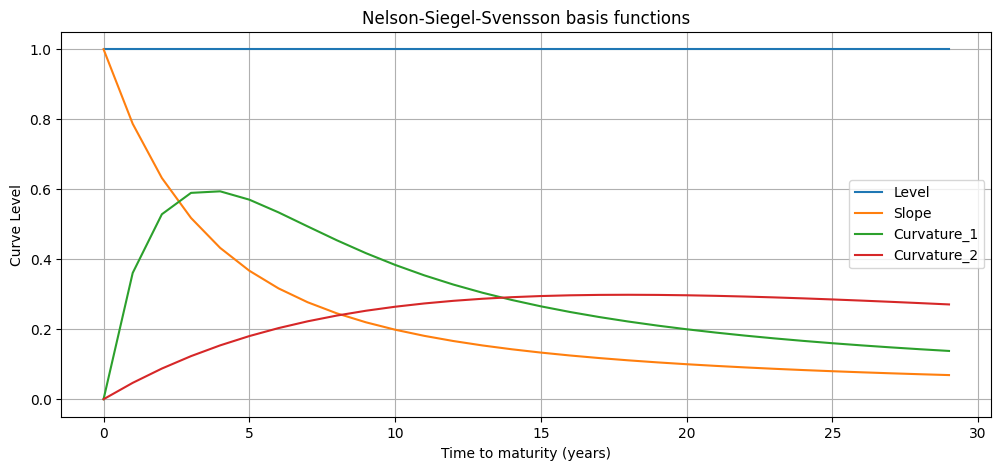

In [15]:

curve_shapes_df = pd.DataFrame([T, nelson_siegel([1, 0, 0, 2], T), 
                                 nelson_siegel([0, 1, 0, 2], T), 
                                 nelson_siegel([0, 0, 2, 2], T)] for T in range(0,30,1))
curve_shapes_df.columns = ['TTM', 'Level', 'Slope', 'Curvature']

curve_shapes_df2 = pd.DataFrame([T, nelson_siegel_extended([1, 0, 0, 2, 0, 0], T), 
                                 nelson_siegel_extended([0, 1, 0, 2, 0, 0], T), 
                                 nelson_siegel_extended([0, 0, 2, 2, 0, 0], T), 
                                 nelson_siegel_extended([0, 0, 0, 2, 1, 10], T)] for T in range(0,30,1))
curve_shapes_df2.columns = ['TTM', 'Level', 'Slope', 'Curvature_1', 'Curvature_2']

print(curve_shapes_df2.head())

plt = curve_shapes_df.plot(x='TTM', y=['Level', 'Slope', 'Curvature'], grid=True, style='-', title='Nelson-Siegel basis functions', figsize=(12,5))
plt.set_ylabel('Curve Level')
plt.set_xlabel('Time to maturity (years)')

plt = curve_shapes_df2.plot(x='TTM', y=['Level', 'Slope', 'Curvature_1', 'Curvature_2'], grid=True, style='-', title='Nelson-Siegel-Svensson basis functions', figsize=(12,5))
plt.set_ylabel('Curve Level')
plt.set_xlabel('Time to maturity (years)')


## c. Constructing smooth Nelson-Siegel hazard rate / survival probability curves

Text(0.5, 0, 'Maturity')

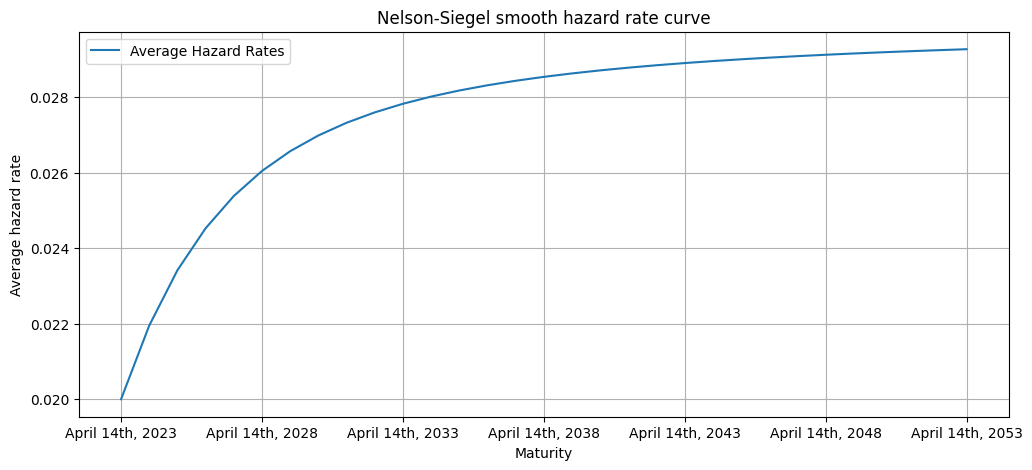

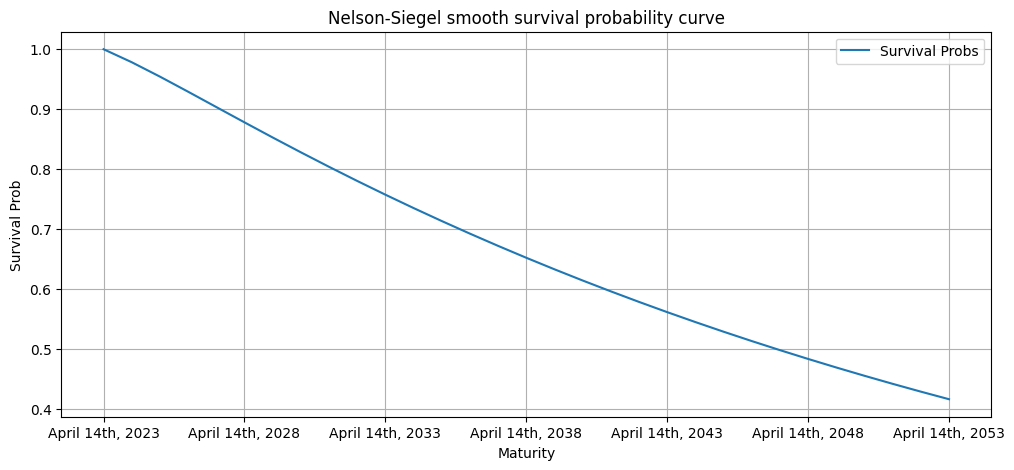

In [16]:
# nelson_siegel_params = [theta1, theta2, theta3, lambda] = [long term level, short - long slope, curvature, lambda]
nelson_siegel_params = [0.0300, -0.0100, -0.0010, 2]

nelson_siegel_surv_prob_dates = [calc_date + ql.Period(T , ql.Years) for T in range(31)]
nelson_siegel_average_hazard_rates = [nelson_siegel(nelson_siegel_params, T) for T in range(31)]
nelson_siegel_surv_prob_levels = [np.exp(-T * nelson_siegel_average_hazard_rates[T]) for T in range(31)]

# nelson_siegel_surv_prob_curve
nelson_siegel_credit_curve = ql.SurvivalProbabilityCurve(nelson_siegel_surv_prob_dates, nelson_siegel_surv_prob_levels, ql.Actual360(), ql.TARGET())
nelson_siegel_credit_curve.enableExtrapolation()
nelson_siegel_credit_curve_handle = ql.DefaultProbabilityTermStructureHandle(nelson_siegel_credit_curve)

nelson_siegel_surv_prob_df = pd.DataFrame(data={'Dates': nelson_siegel_surv_prob_dates,
                                          'Average Hazard Rates': nelson_siegel_average_hazard_rates,
                                          'Survival Probs': nelson_siegel_surv_prob_levels})
# print(nelson_siegel_surv_prob_df)

plt = nelson_siegel_surv_prob_df.plot(x='Dates', y=['Average Hazard Rates'], grid=True, style='-', title='Nelson-Siegel smooth hazard rate curve', figsize=(12,5))
plt.set_ylabel('Average hazard rate')
plt.set_xlabel('Maturity')

plt = nelson_siegel_surv_prob_df.plot(x='Dates', y=['Survival Probs'], grid=True, style='-', title='Nelson-Siegel smooth survival probability curve', figsize=(12,5))
plt.set_ylabel('Survival Prob')
plt.set_xlabel('Maturity')



## d. Pricing risky bonds in Nelson-Siegel model (with Credit Risk)

In [17]:
# bond_recovery_rate
bond_recovery_rate = 0.4

# nelson_siegel_risky_bond_engine
nelson_siegel_risky_bond_engine = ql.RiskyBondEngine(nelson_siegel_credit_curve_handle, bond_recovery_rate, sofr_yield_curve_handle)
fixed_rate_bond.setPricingEngine(nelson_siegel_risky_bond_engine)

# Price risky bond using Nelson-Siegel survival probability curve
nelson_siegel_risky_bond_price = fixed_rate_bond.cleanPrice()
nelson_siegel_risky_bond_yield = fixed_rate_bond.bondYield(nelson_siegel_risky_bond_price, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100

print('nelson_siegel_surv_prob_risky_bond_price:', nelson_siegel_risky_bond_price)
print('nelson_siegel_surv_prob_risky_bond_yield:', nelson_siegel_risky_bond_yield)

# Compute the credit I-Spread (relative to risk-free SOFR bond)
nelson_siegel_risky_bond_credit_ispread = (nelson_siegel_risky_bond_yield - risk_free_bond_yield) * 1e2
print('nelson_siegel_risky_bond_ispread:', nelson_siegel_risky_bond_credit_ispread)

# Compute z-spread
nelson_siegel_risky_bond_zspread = ql.BondFunctions.zSpread(fixed_rate_bond, nelson_siegel_risky_bond_price, sofr_yield_curve, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 1e4
print('nelson_siegel_risky_bond_zspread:', nelson_siegel_risky_bond_zspread)



nelson_siegel_surv_prob_risky_bond_price: 95.95463373300109
nelson_siegel_surv_prob_risky_bond_yield: 5.134316444396973
nelson_siegel_risky_bond_ispread: 155.3614800466426
nelson_siegel_risky_bond_zspread: 152.96353195435728
